In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_df = pd.read_csv("data.csv", parse_dates=["Date"])

format_demand = lambda x: pd.to_numeric(str(x).strip("()"))

data_df["Order_Demand"] = [format_demand(x[1]["Order_Demand"]) for x in data_df.iterrows()]

formatted_df = data_df[data_df["Order_Demand"] != 0].dropna()

print(formatted_df.dtypes)

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object


In [160]:
formatted_df.pivot_table(values="Order_Demand", index="Product_Category", aggfunc=["count", np.sum, np.mean, np.median, min, max])

,count,sum,mean,median,min,max
,Order_Demand,Order_Demand,Order_Demand,Order_Demand,Order_Demand,Order_Demand
Product_Category,,,,,,
Category_001,97431,1757473,18.038130,5,1,2075
Category_002,77,628,8.155844,4,1,60
Category_003,4131,392950,95.122246,32,1,1860
Category_004,327,99046,302.892966,200,1,2400
Category_005,101003,199674520,1976.916725,500,10,500000
Category_006,35262,405571330,11501.654189,3000,1,1000000
Category_007,81930,128691531,1570.749799,100,1,1144000
Category_008,1554,17568,11.305019,4,1,200


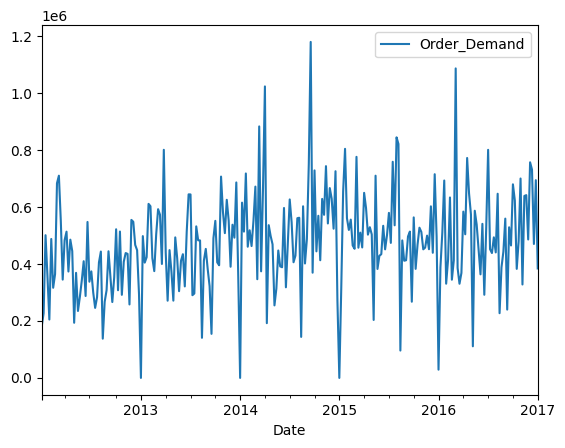

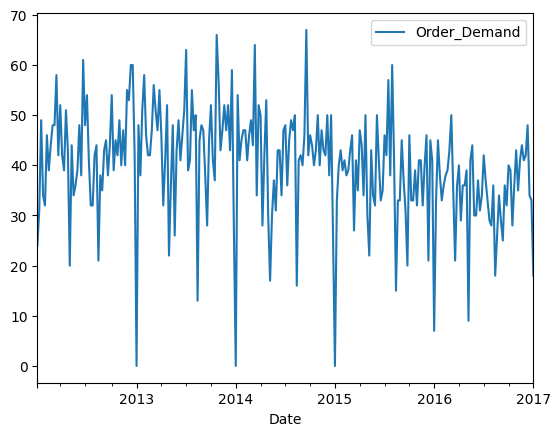

In [208]:
DATA_FREQ = "W"
POLY_REG = 8
RIDGE = 8

product1295 = formatted_df[formatted_df["Product_Code"] == "Product_1295"]

product1295_pivot = product1295.pivot_table(values="Order_Demand", index="Date", aggfunc=[np.sum, "count"])

# grouped_product1295 = product1295.groupby("Date")["Order_Demand"].sum().reset_index()
weekly_product1295 = product1295.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()

weekly_product1295.plot(x="Date", y="Order_Demand", kind="line")
# plt.show()

# order_count_product1295 = product1295.groupby("Date")["Order_Demand"].count().reset_index()
weeklyorder_product1295 = product1295.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).count().reset_index()

weeklyorder_product1295.plot(x="Date", y="Order_Demand", kind="line")
plt.show()

In [209]:
product1295_pivot

,sum,count
,Order_Demand,Order_Demand
Date,,
2012-01-05,78700,8
2012-01-06,102100,16
2012-01-10,134000,9
2012-01-11,37600,8
2012-01-12,32100,9
...,...,...
2016-12-21,248000,11
2016-12-22,220000,5


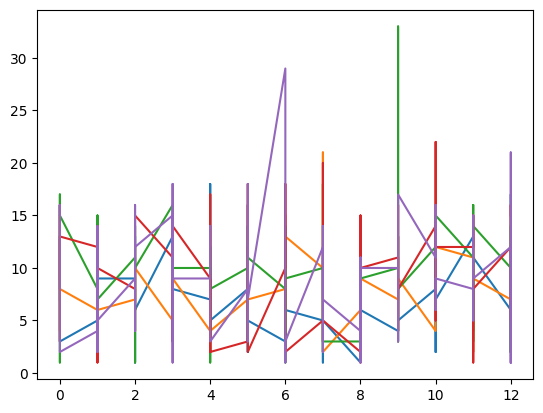

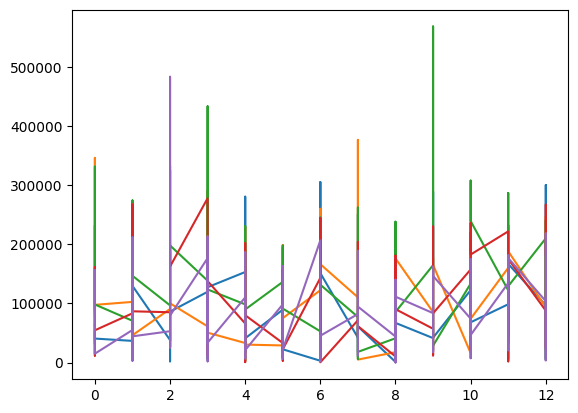

In [210]:
from datetime import datetime
import copy

def dt_to_n(dt):
    dt_unix = dt.timestamp()
    year_unix = datetime(dt.year, 1, 1).timestamp()
    relative_unix = dt_unix - year_unix
    # TODO: Make this react to the DATA_FREQ value
    return relative_unix//(86400 * 7 * 4)

prod1295 = copy.copy(product1295_pivot)
prod1295["days"] = [dt_to_n(i) for i,_ in prod1295.iterrows()]

prod1295["year"] = [i.year for i,_ in prod1295.iterrows()]

plt_2d = plt.figure().add_subplot()

annual_data = prod1295.groupby("year")
i=0
t = len(annual_data)
for year, year_data in reversed(tuple(annual_data)):
    plt_2d.plot(year_data["days"], year_data[("count","Order_Demand")])
    i+=1

plt_2d_sum = plt.figure().add_subplot()
annual_data_sum = prod1295.groupby("year")
i=0
t = len(annual_data_sum)
for year, year_data in reversed(tuple(annual_data_sum)):
    plt_2d_sum.plot(year_data["days"], year_data[("sum","Order_Demand")])
    i+=1
plt.show()

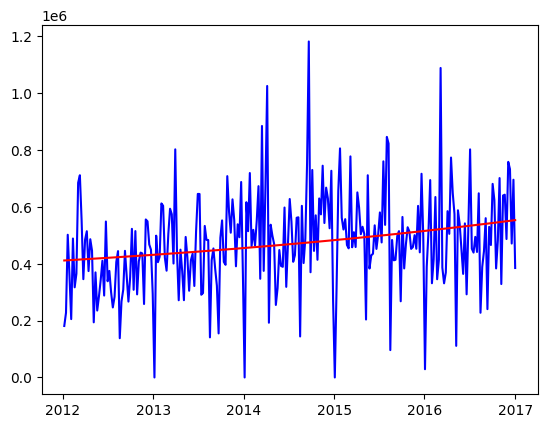

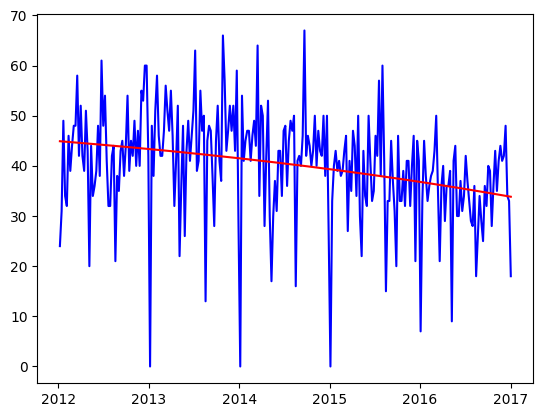

In [211]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

order_quantity_model1295 = LinearRegression()
poly_features_1 = PolynomialFeatures(degree=POLY_REG, include_bias=False)

modelX_1 = weekly_product1295["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_1 = poly_features_1.fit_transform(modelX_1)

order_quantity_model1295.fit(polyX_1, weekly_product1295["Order_Demand"])

# intercept = linear_model.intercept_
# coef = linear_model.coef_

# x_vals = np.linspace(modelX.min(), modelX.max(), 261).reshape(261,1)
polyX_new_1 = poly_features_1.transform(modelX_1)
# y_new = linear_model.predict(polyX_new)

plt.plot(weekly_product1295["Date"], weekly_product1295["Order_Demand"], label="Data", color="blue")
plt.plot(weekly_product1295["Date"], order_quantity_model1295.predict(polyX_new_1), color="red", label="Regression Line")
plt.show()


order_num_model1295 = LinearRegression()
poly_features_2 = PolynomialFeatures(degree=POLY_REG, include_bias=False)

modelX_2 = weeklyorder_product1295["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_2 = poly_features_2.fit_transform(modelX_2)

order_num_model1295.fit(polyX_2, weeklyorder_product1295["Order_Demand"])

# intercept = linear_model.intercept_
# coef = linear_model.coef_

# x_vals = np.linspace(modelX.min(), modelX.max(), 261).reshape(261,1)
polyX_new_2 = poly_features_2.transform(modelX_2)
# y_new = linear_model.predict(polyX_new)

plt.plot(weeklyorder_product1295["Date"], weeklyorder_product1295["Order_Demand"], label="Data", color="blue")
plt.plot(weeklyorder_product1295["Date"], order_num_model1295.predict(polyX_new_2), color="red", label="Regression Line")
plt.show()

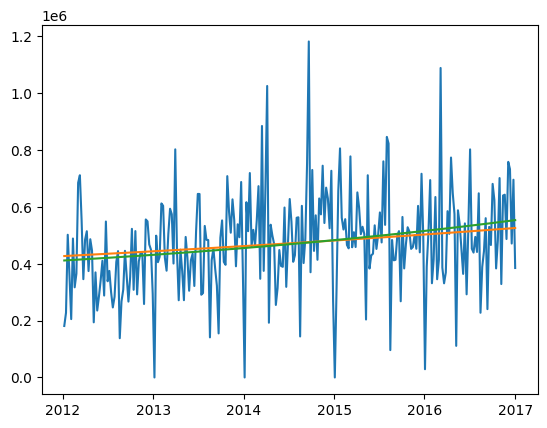

In [212]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

ridge_reg = Ridge(alpha=1000, solver="sag", random_state=42)
Xridge = weekly_product1295["Date"].values.astype(np.int64)[:, np.newaxis]
#print(type(Xridge))
ridge_reg = Pipeline([
        ("poly_features", PolynomialFeatures(degree=RIDGE, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", ridge_reg),
    ])
ridge_reg.fit(Xridge,weekly_product1295["Order_Demand"])

plt.plot(weekly_product1295["Date"], weekly_product1295["Order_Demand"], label="Data")
plt.plot(weekly_product1295["Date"], ridge_reg.predict(Xridge), label="Regression Line")
plt.plot(weekly_product1295["Date"], order_quantity_model1295.predict(polyX_new_1), label="Regression Line")
plt.show()

In [213]:
product_demand_pivot = formatted_df.pivot_table(values="Order_Demand", index="Product_Code", aggfunc=["count", np.sum])
# print(product_demand_pivot)
order_quantity = product_demand_pivot.sort_values(by=("sum", "Order_Demand"), ascending=False)
order_number = product_demand_pivot.sort_values(by=("count", "Order_Demand"), ascending=False)
print(order_quantity.head())
print(order_number.head())

                    count          sum
             Order_Demand Order_Demand
Product_Code                          
Product_1359        16885    472474000
Product_1248         6323    289117000
Product_0083         1984    210651000
Product_1341         2659    169777000
Product_1295        10464    123303000
                    count          sum
             Order_Demand Order_Demand
Product_Code                          
Product_1359        16885    472474000
Product_1295        10464    123303000
Product_1378         9672     83632700
Product_0620         9391        56789
Product_1286         8804    101566400


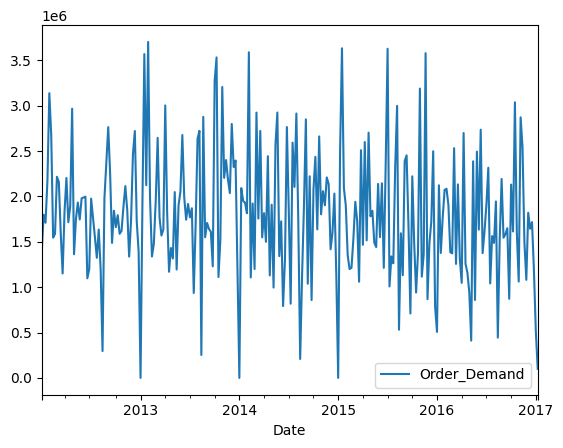

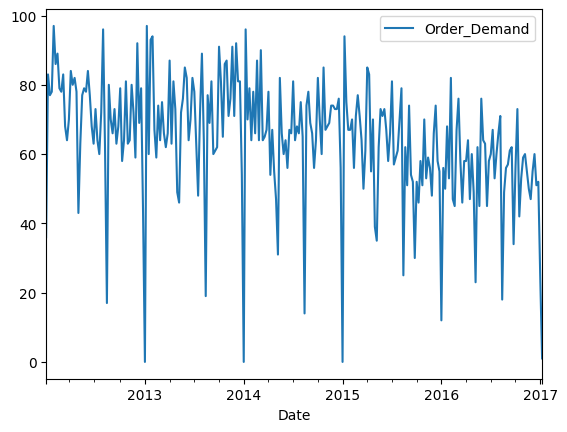

In [214]:
product1359 = formatted_df[formatted_df["Product_Code"] == "Product_1359"]

# grouped_product1295 = product1295.groupby("Date")["Order_Demand"].sum().reset_index()
weekly_product1359 = product1359.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).sum().reset_index()
weekly_product1359.plot(x="Date", y="Order_Demand", kind="line")
# plt.show()

# order_count_product1295 = product1295.groupby("Date")["Order_Demand"].count().reset_index()
weeklyorder_product1359 = product1359.groupby(pd.Grouper(key="Date", freq=DATA_FREQ)).count().reset_index()
weeklyorder_product1359.plot(x="Date", y="Order_Demand", kind="line")

plt.show()

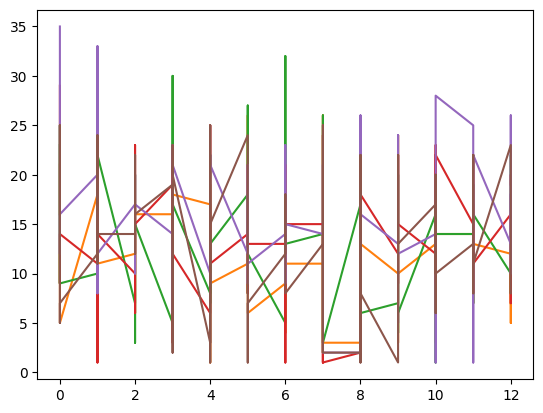

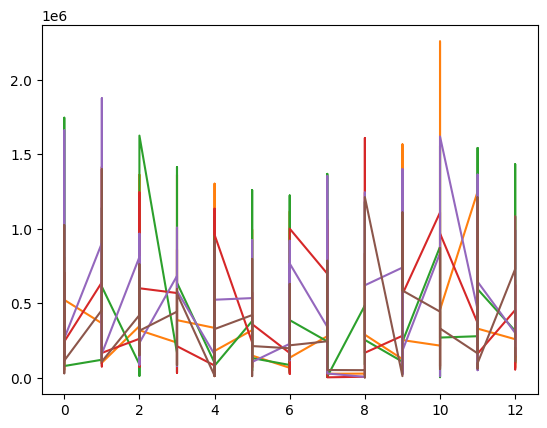

In [215]:
product1359_pivot = product1359.pivot_table(values="Order_Demand", index="Date", aggfunc=[np.sum, "count"])

prod1359 = copy.copy(product1359_pivot)
prod1359["days"] = [dt_to_n(i) for i,_ in prod1359.iterrows()]

prod1359["year"] = [i.year for i,_ in prod1359.iterrows()]

plt_2d = plt.figure().add_subplot()

annual_data = prod1359.groupby("year")
i=0
t = len(annual_data)
for year, year_data in reversed(tuple(annual_data)):
    plt_2d.plot(year_data["days"], year_data[("count","Order_Demand")])
    i+=1

plt_2d_sum = plt.figure().add_subplot()
annual_data_sum_2 = prod1359.groupby("year")
i=0
t = len(annual_data_sum_2)
for year, year_data in reversed(tuple(annual_data_sum_2)):
    plt_2d_sum.plot(year_data["days"], year_data[("sum","Order_Demand")])
    i+=1
plt.show()


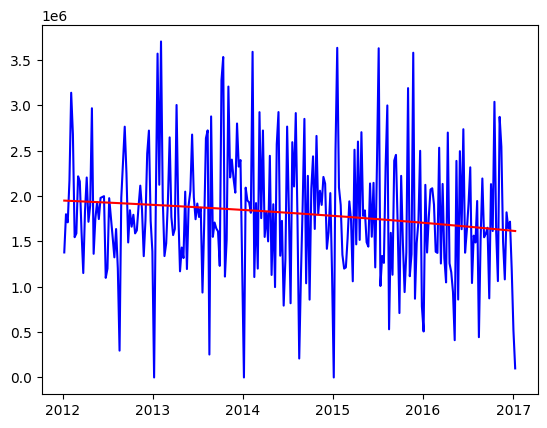

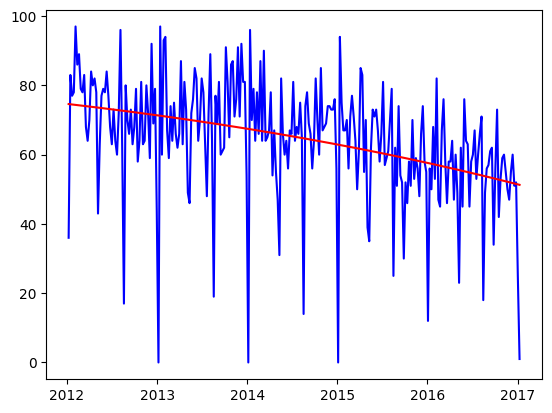

In [217]:
order_quantity_model1359 = LinearRegression()
poly_features_3 = PolynomialFeatures(degree=POLY_REG, include_bias=False)

modelX_3 = weekly_product1359["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_3 = poly_features_3.fit_transform(modelX_3)

order_quantity_model1359.fit(polyX_3, weekly_product1359["Order_Demand"])

# intercept = linear_model.intercept_
# coef = linear_model.coef_

# x_vals = np.linspace(modelX.min(), modelX.max(), 261).reshape(261,1)
polyX_new_3 = poly_features_3.transform(modelX_3)
# y_new = linear_model.predict(polyX_new)

plt.plot(weekly_product1359["Date"], weekly_product1359["Order_Demand"], label="Data", color="blue")
plt.plot(weekly_product1359["Date"], order_quantity_model1359.predict(polyX_new_3), color="red", label="Regression Line")
plt.show()


order_num_model1359 = LinearRegression()
poly_features_4 = PolynomialFeatures(degree=POLY_REG, include_bias=False)

modelX_4 = weeklyorder_product1359["Date"].values.astype(np.int64)[:, np.newaxis]
polyX_4 = poly_features_4.fit_transform(modelX_4)

order_num_model1359.fit(polyX_4, weeklyorder_product1359["Order_Demand"])

# intercept = linear_model.intercept_
# coef = linear_model.coef_

# x_vals = np.linspace(modelX.min(), modelX.max(), 261).reshape(261,1)
polyX_new_4 = poly_features_4.transform(modelX_4)
# y_new = linear_model.predict(polyX_new)

plt.plot(weeklyorder_product1359["Date"], weeklyorder_product1359["Order_Demand"], label="Data", color="blue")
plt.plot(weeklyorder_product1359["Date"], order_num_model1359.predict(polyX_new_4), color="red", label="Regression Line")
plt.show()